<a href="https://www.kaggle.com/code/habibulbasher01644/olive-leaf-image-classification?scriptVersionId=223074003" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [86]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/olive-leaf-image-dataset'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import all necessary library

In [87]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import collections 
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16, VGG19, MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input  # MobileNet V1 preprocessing
from tensorflow.keras.models import Model



# Approch:1 Custom CNN model without data augmentation

## 1. Define Dataset Paths

In [88]:
train_dir = '/kaggle/input/olive-leaf-image-dataset/dataset/train'
test_dir = '/kaggle/input/olive-leaf-image-dataset/dataset/test'
batch_size = 32
img_size = (224, 224)

## 2. Load Dataset Without Data Augmentation

In [89]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                          train_dir, 
                          target_size=img_size, 
                          batch_size=batch_size, 
                          class_mode='categorical',
                          shuffle=True)
test_generator = test_datagen.flow_from_directory(
                          test_dir, 
                          target_size=img_size, 
                          batch_size=batch_size, 
                          class_mode='categorical', 
                          shuffle=False)

Found 2720 images belonging to 3 classes.
Found 680 images belonging to 3 classes.


## 3.dataset summary

In [90]:
# Print dataset summary
print(f"Found {train_generator.samples} images belonging to {len(train_generator.class_indices)} classes in the training set.")
print(f"Found {test_generator.samples} images belonging to {len(test_generator.class_indices)} classes in the testing set.")
print(f"Class Labels: {train_generator.class_indices}")

# Function to count images per class
def count_images_per_class(directory, class_indices):
    class_counts = Counter()
    for class_name, class_index in class_indices.items():
        class_path = os.path.join(directory, class_name)
        class_counts[class_name] = len(os.listdir(class_path)) if os.path.exists(class_path) else 0
    return class_counts

# Get per-class image counts
train_class_counts = count_images_per_class(train_dir, train_generator.class_indices)
test_class_counts = count_images_per_class(test_dir, test_generator.class_indices)

# Print per-class distribution
print("\nTraining Data:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} images")

print("\nTesting Data:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count} images")

Found 2720 images belonging to 3 classes in the training set.
Found 680 images belonging to 3 classes in the testing set.
Class Labels: {'Healthy': 0, 'aculus_olearius': 1, 'olive_peacock_spot': 2}

Training Data:
Healthy: 830 images
aculus_olearius: 690 images
olive_peacock_spot: 1200 images

Testing Data:
Healthy: 220 images
aculus_olearius: 200 images
olive_peacock_spot: 260 images


## 4.Define Custom CNN Model

In [91]:

def build_custom_cnn():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())  # Batch Normalization only in Block 1
    model.add(MaxPooling2D((2, 2)))

    # Block 2
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 3
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 4
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 5
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))  # Dropout to reduce overfitting
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    return model

custom_cnn_model = build_custom_cnn()
custom_cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_88 (Conv2D)                   │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_89 (Conv2D)                   │ (None, 224, 224, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_90 (Conv2D)                   │ (None, 224, 224, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_91 (Conv2D)                   │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_92 (Conv2D)                   │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_93 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_94 (Conv2D)                   │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_26 (Flatten)                 │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 1000)                │      12,545,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 1000)                │       1,001,0

 Total params: 14,730,155 (56.19 MB)

 Trainable params: 14,730,123 (56.19 MB)

 Non-trainable params: 32 (128.00 B)

## 5.Train and Evaluate Model

In [92]:
optimizer = Adam(learning_rate=0.0001)

accuracy_history = []
loss_history = []
test_accuracy_history = []

def train_and_evaluate(model):
    print(f"🔹 Training Model using Adam optimizer...")

    # Compile Model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train Model
    history = model.fit(train_generator, validation_data=test_generator, epochs=40, batch_size=batch_size)

    # Store accuracy and loss values for each epoch
    accuracy_history.append(history.history['val_accuracy'])
    loss_history.append(history.history['val_loss'])

    # Evaluate Model
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    y_true = test_generator.classes
    
    # Test Accuracy Calculation
    test_accuracy = np.sum(y_pred == y_true) / len(y_true)
    test_accuracy_history.append(test_accuracy)

    print(f"\n🔹 Classification Report for Adam:")
    print(classification_report(y_true, y_pred))

    print("\n🔹 Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())

    # Labels, title and ticks
    plt.title('Confusion Matrix for Model Evaluation')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    print(f"\n🔹 Test Accuracy for Adam: {test_accuracy:.4f}")

    # Plot Accuracy and Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Adam - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Adam - Loss')

    plt.show()


## 6.Train and evaluate with Adam optimizer

🔹 Training Model using Adam optimizer...
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.4740 - loss: 0.9919 - val_accuracy: 0.4029 - val_loss: 1.0619
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.7442 - loss: 0.5822 - val_accuracy: 0.6618 - val_loss: 0.9367
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.7985 - loss: 0.4844 - val_accuracy: 0.5956 - val_loss: 0.8751
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.8357 - loss: 0.4222 - val_accuracy: 0.6588 - val_loss: 0.8077
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.8364 - loss: 0.4126 - val_accuracy: 0.6397 - val_loss: 0.7556
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.8712 - loss: 0.3377 - val_accuracy: 0.7324 - val_loss: 0.6421
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.8754 - loss: 0.3164 - val_accuracy: 0.6103 - val_loss: 0.9074
Epoch 8/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.8871 - loss: 0.2866 - val_accuracy: 0.786

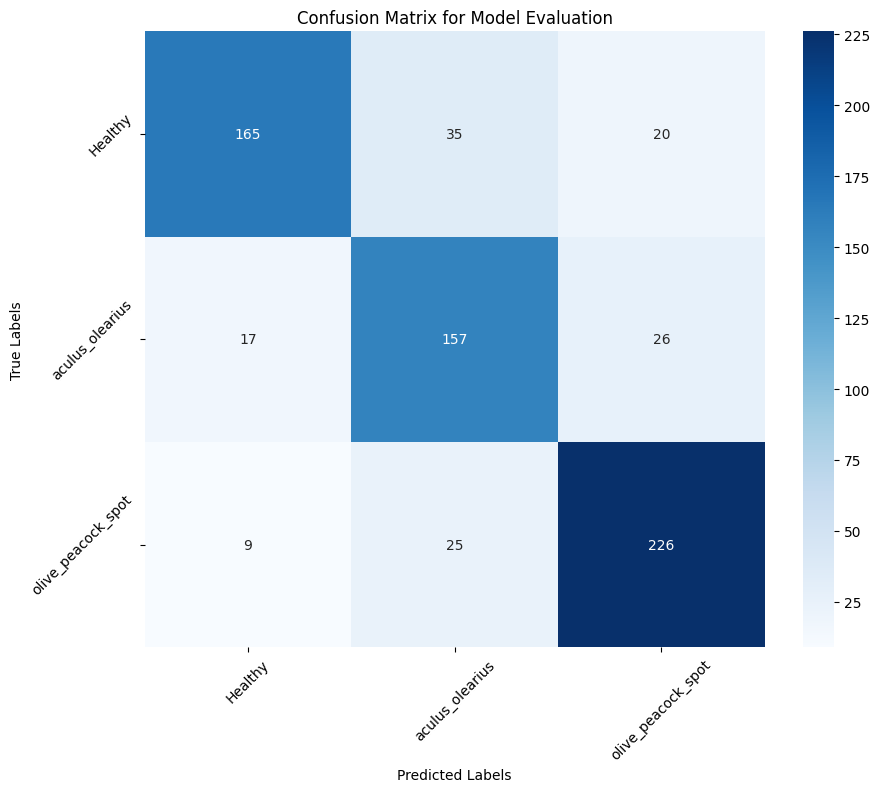

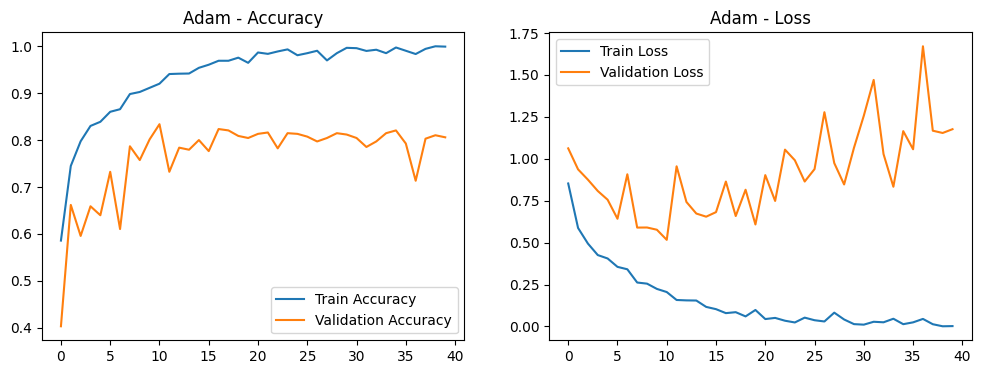

In [93]:
model = build_custom_cnn()

# Train and evaluate with Adam optimizer
train_and_evaluate(model)


# Approch:2 Custom CNN model with data augmentation

In [94]:
optimizer1 = Adam(learning_rate=0.0001)

# Create dictionaries to store accuracy, loss, and test accuracy values for Adam optimizer
accuracy_history1 = []
loss_history1 = []
test_accuracy_history1 = []

## 1.Data Augmentation

In [95]:
train_datagen1  ImageDataGenerator(
    rescale=1./255,  # Rescale image pixel values to [0, 1]
    rotation_range=50,  # Random rotations between -30 to 30 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20%
    height_shift_range=0.2,  # Randomly shift images vertically by 20%
    shear_range=0.2,  # Shear transformation
    zoom_range= 0.4, # Random zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels after transformations
)

test_datagen1= ImageDataGenerator(rescale=1./255)


## 2.Load Dataset With Data Augmentation

In [96]:
train_generator1= train_datagen1.flow_from_directory(
                          train_dir, 
                          target_size=img_size, 
                          batch_size=batch_size, 
                          class_mode='categorical',
                          shuffle=True)
test_generator1= test_datagen1.flow_from_directory(
                          test_dir, 
                          target_size=img_size, 
                          batch_size=batch_size, 
                          class_mode='categorical', 
                          shuffle=False)

Found 2720 images belonging to 3 classes.
Found 680 images belonging to 3 classes.


## 2.Train and Evaluating Model

In [97]:
def train_and_evaluate_with_augmentation(model):
    print(f"🔹 Training Model using Adam optimizer with Data Augmentation...")

    # Compile Model
    model.compile(optimizer=optimizer1, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train Model with augmented data
    history1 = model.fit(
        train_generator1,  # Augmented training data
        validation_data=test_generator1,  # Validation data
        epochs=40
    )

    # Store accuracy and loss values for each epoch
    accuracy_history1.append(history1.history['val_accuracy'])
    loss_history1.append(history1.history['val_loss'])

    # Evaluate Model
    y_pred = np.argmax(model.predict(test_generator1), axis=1)
    y_true = test_generator1.classes

    cm = confusion_matrix(y_true, y_pred)
    # Test Accuracy Calculation
    test_accuracy1 = np.sum(y_pred == y_true) / len(y_true)
    test_accuracy_history1.append(test_accuracy1)

    print(f"\n🔹 Classification Report for Adam with Data Augmentation:")
    print(classification_report(y_true, y_pred))

    print("\n🔹 Confusion Matrix:")
    print(cm)
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator1.class_indices.keys(), yticklabels=test_generator1.class_indices.keys())

    # Labels, title and ticks
    plt.title('Confusion Matrix for Model Evaluation')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    print(f"\n🔹 Test Accuracy for Adam with Data Augmentation: {test_accuracy1:.4f}")

    # Plot Accuracy and Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Train Accuracy')
    plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Adam with Data Augmentation - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Train Loss')
    plt.plot(history1.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Adam with Data Augmentation - Loss')

    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🔹 Training Model using Adam optimizer with Data Augmentation...
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 391ms/step - accuracy: 0.4598 - loss: 1.0209 - val_accuracy: 0.4956 - val_loss: 1.0406
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 382ms/step - accuracy: 0.6803 - loss: 0.6887 - val_accuracy: 0.4912 - val_loss: 0.9904
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 375ms/step - accuracy: 0.7295 - loss: 0.6243 - val_accuracy: 0.5515 - val_loss: 0.9198
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 378ms/step - accuracy: 0.7564 - loss: 0.5614 - val_accuracy: 0.6412 - val_loss: 0.7737
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 385ms/step - accuracy: 0.7729 - loss: 0.5570 - val_accuracy: 0.7118 - val_loss: 0.7399
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 376ms/step - accuracy: 0.7777 - loss: 0.5406 - val_accuracy: 0.6176 - val_loss: 0.7752
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 377ms/step - accuracy: 0.7854 - loss: 0.5177 - val_accuracy: 0.6324 - val_loss: 0.7669
Epoch 8/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 378ms/step - accuracy: 0.7934 - loss: 0.5061 - val_accuracy: 0.582

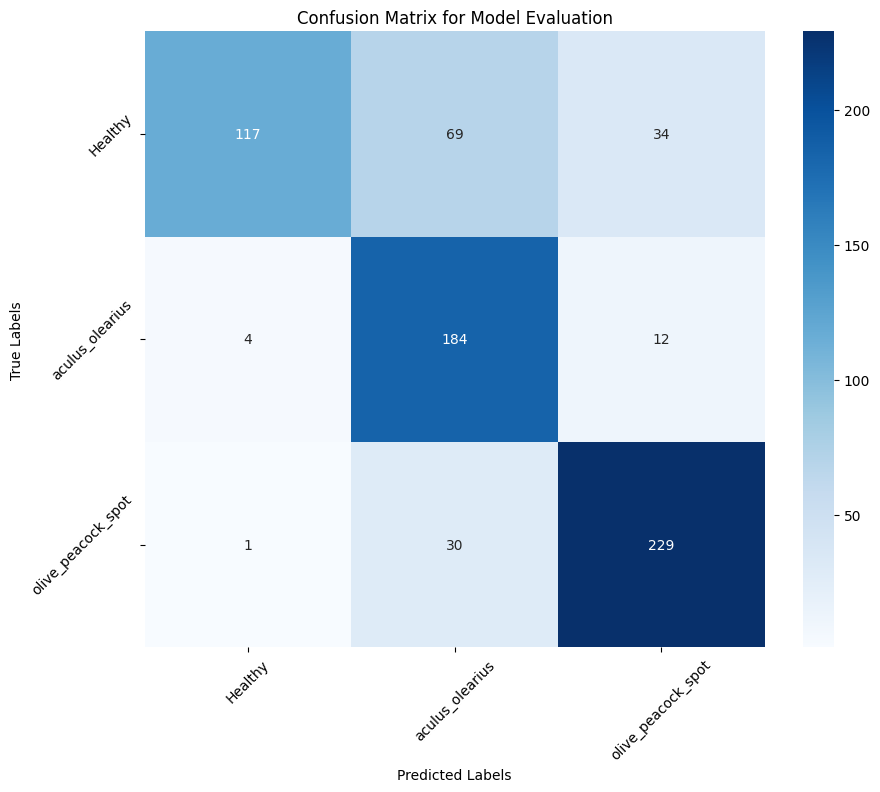

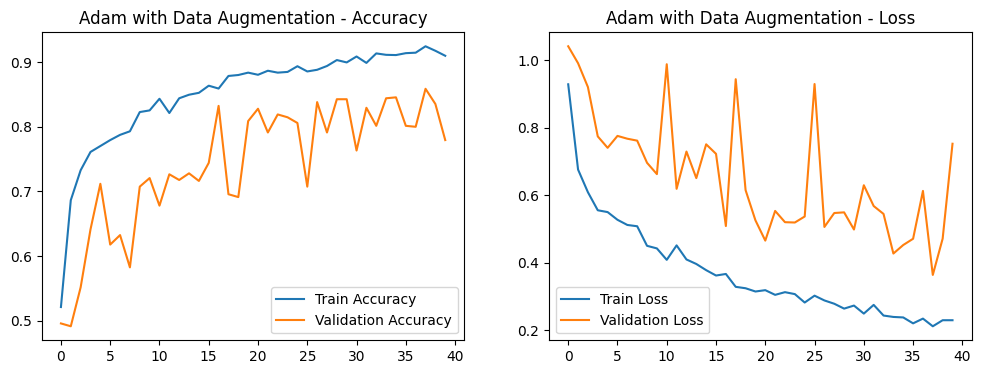

In [98]:

# Build the custom CNN model (make sure to define your model here)
model = build_custom_cnn()

# Train and evaluate with Adam optimizer and data augmentation
train_and_evaluate_with_augmentation(model)


# Approach 3: Without data augmentation Using 3 Pre-trained CNN Model. 
### VGG16,VGG19 and MobileNet

## 1. Function to build model (VGG16, VGG19, MobileNet)


In [99]:

def build_model(base_model):
    for layer in base_model.layers:
        layer.trainable = False  # Freeze convolutional layers
    
    x = Flatten()(base_model.output)
    x = Dense(1000, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation="softmax")(x)  # 3-class classification
    
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [100]:

# Load Pre-trained Models
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
vgg19_base = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
mobilenet_base = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [101]:

# Build Models
vgg16_model = build_model(vgg16_base)
vgg19_model = build_model(vgg19_base)
mobilenet_model = build_model(mobilenet_base)

## 2.Data Preprocessing (No Augmentation, Only Rescaling)

In [102]:

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/train',  # Replace with dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/test',  # Replace with dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2720 images belonging to 3 classes.
Found 680 images belonging to 3 classes.


## 3.Train models

In [103]:

# Train Models
print("🔹 Training VGG16 Model...")
history_vgg16 = vgg16_model.fit(train_generator, validation_data=test_generator, epochs=40, batch_size=32)

print("🔹 Training VGG19 Model...")
history_vgg19 = vgg19_model.fit(train_generator, validation_data=test_generator, epochs=40, batch_size=32)


print("🔹 Training MobileNet Model...")
history_mobilenet = mobilenet_model.fit(train_generator, validation_data=test_generator, epochs=40, batch_size=32)


🔹 Training VGG16 Model...
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.5172 - loss: 1.1557 - val_accuracy: 0.7294 - val_loss: 0.6967
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.7658 - loss: 0.5638 - val_accuracy: 0.7838 - val_loss: 0.5579
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.8474 - loss: 0.4207 - val_accuracy: 0.7294 - val_loss: 0.6245
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/step - accuracy: 0.8480 - loss: 0.3880 - val_accuracy: 0.7044 - val_loss: 0.6765
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.8801 - loss: 0.3232 - val_accuracy: 0.8132 - val_loss: 0.4783
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - accuracy: 0.9022 - loss: 0.2813 - val_accuracy: 0.8235 - val_loss: 0.4366
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - accuracy: 0.9121 - loss: 0.2389 - val_accuracy: 0.8265 - val_loss: 0.4259
Epoch 8/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 0.9068 - loss: 0.2397 - val_accuracy: 0.827

## 4.Evaluate models

In [104]:

# Evaluate Models
def evaluate_model(model, test_generator, model_name):
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    y_true = test_generator.classes
    
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\n🔹 {model_name} Test Accuracy: {test_acc:.4f}")
    
    print(f"\n🔹 Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred))

    print(f"\n🔹 Confusion Matrix for {model_name}:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.8505 - loss: 0.4968

🔹 VGG16 Test Accuracy: 0.8309

🔹 Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       220
           1       0.94      0.74      0.83       200
           2       0.79      0.89      0.84       260

    accuracy                           0.83       680
   macro avg       0.85      0.82      0.83       680
weighted avg       0.84      0.83      0.83       680


🔹 Confusion Matrix for VGG16:
[[185   4  31]
 [ 23 148  29]
 [ 22   6 232]]


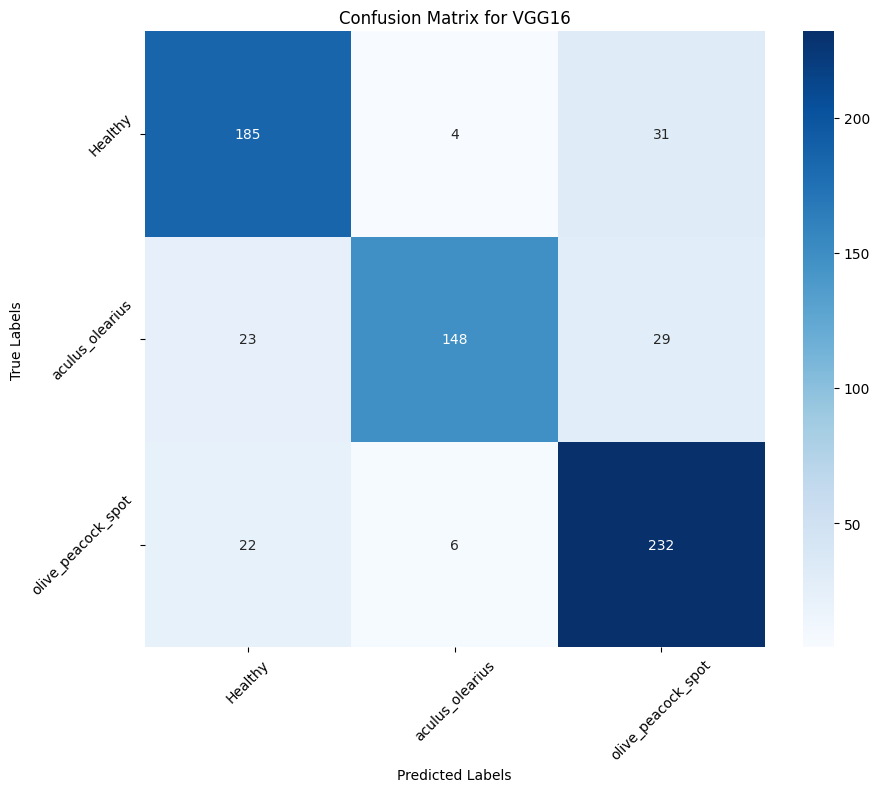

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.8414 - loss: 0.4735

🔹 VGG19 Test Accuracy: 0.8250

🔹 Classification Report for VGG19:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       220
           1       0.83      0.79      0.81       200
           2       0.80      0.88      0.84       260

    accuracy                           0.82       680
   macro avg       0.83      0.82      0.82       680
weighted avg       0.83      0.82      0.82       680


🔹 Confusion Matrix for VGG19:
[[175  13  32]
 [ 18 157  25]
 [ 11  20 229]]


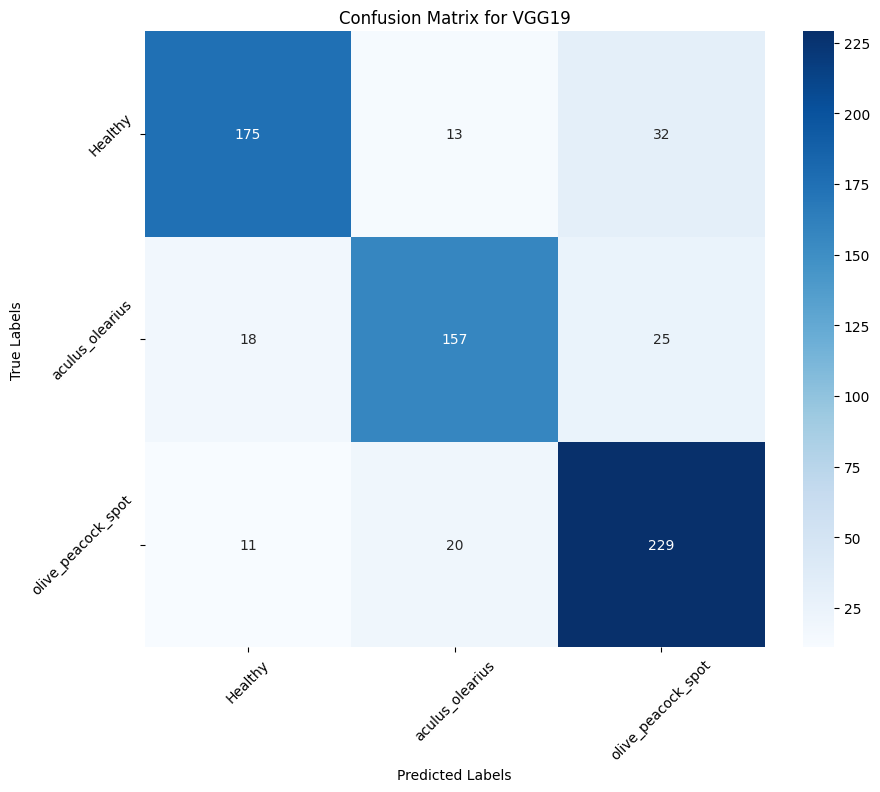

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9203 - loss: 0.8665

🔹 MobileNet Test Accuracy: 0.9044

🔹 Classification Report for MobileNet:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       220
           1       0.84      0.94      0.89       200
           2       0.92      0.88      0.90       260

    accuracy                           0.90       680
   macro avg       0.90      0.91      0.90       680
weighted avg       0.91      0.90      0.90       680


🔹 Confusion Matrix for MobileNet:
[[197  12  11]
 [  3 189   8]
 [  8  23 229]]


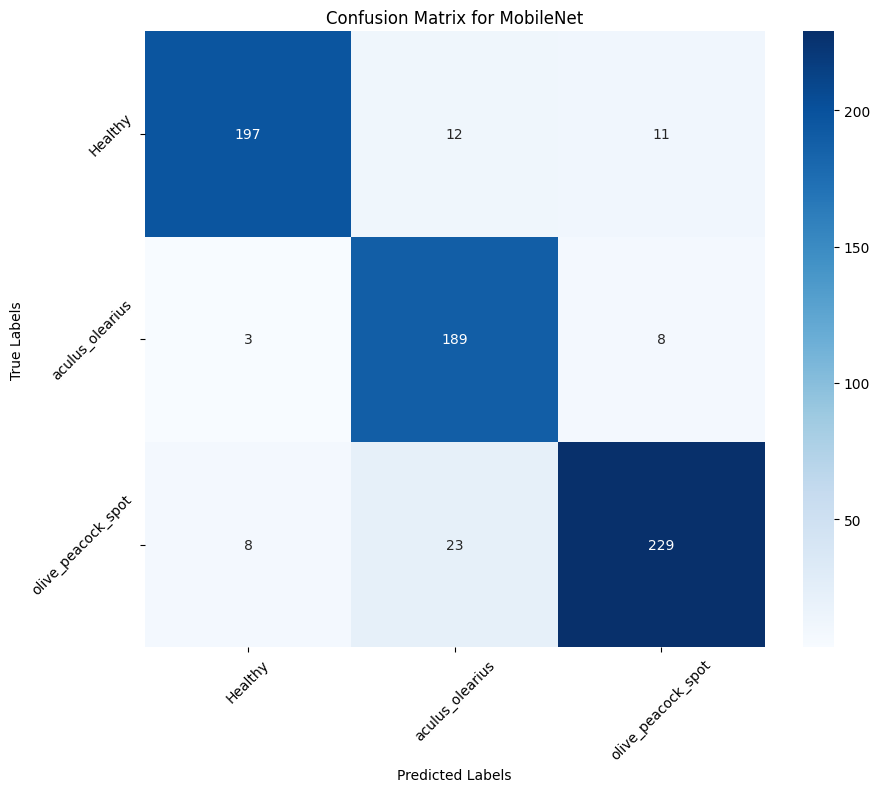

In [105]:

# Evaluate VGG16, VGG19, MobileNetV3
evaluate_model(vgg16_model, test_generator, "VGG16")
evaluate_model(vgg19_model, test_generator, "VGG19")
evaluate_model(mobilenet_model, test_generator, "MobileNet")

## 5.Plot Accuracy & Loss

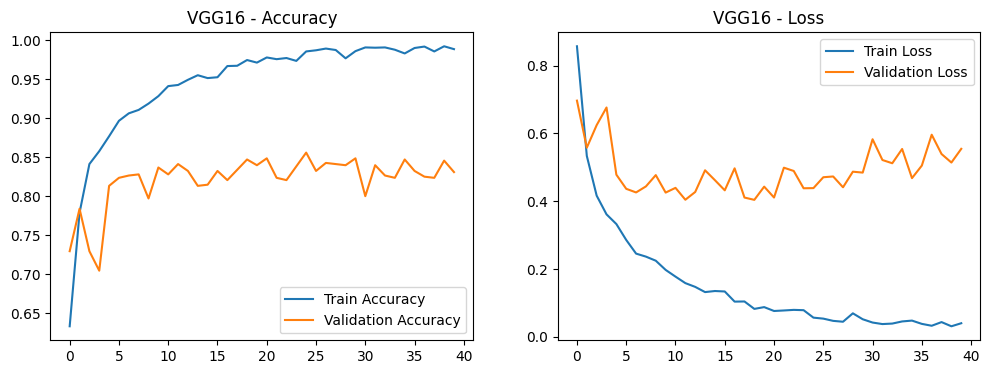

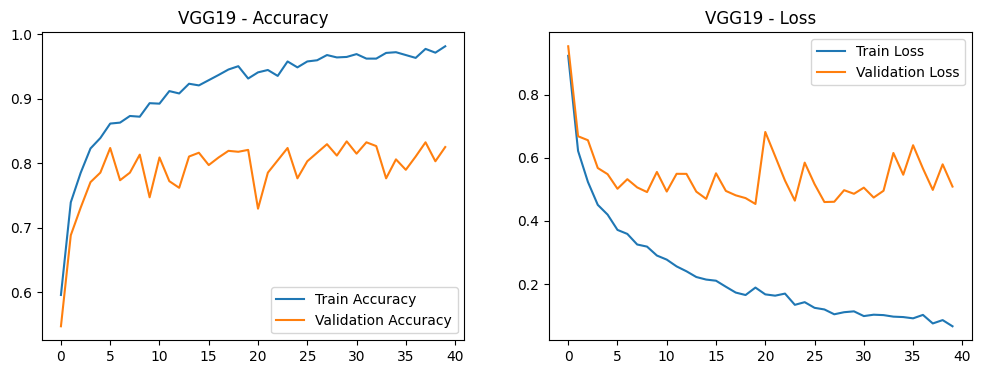

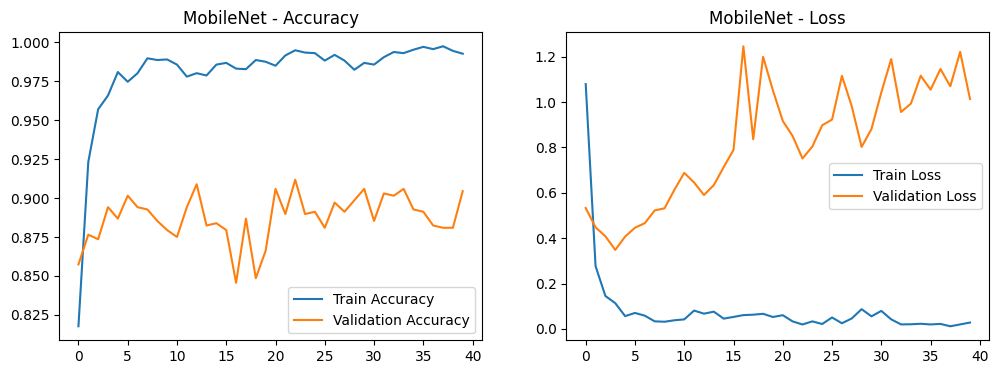

In [106]:

def plot_results(history, model_name):
    plt.figure(figsize=(12, 4))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss')

    plt.show()

# Plot for all models
plot_results(history_vgg16, "VGG16")
plot_results(history_vgg19, "VGG19")
plot_results(history_mobilenet, "MobileNet")

# Data Augmentation
## ImageDataGenerator
    
* rescale: Makes the image numbers smaller so the computer can understand.(rescale=1./255 - Makes all pixel values between 0 and 1)
* rotation_range: Spins the image around.
* width_shift_range and height_shift_range: Moves the image left/right or up/down.
* shear_range: Tilts the image.
* zoom_range: Zooms in or out.
* horizontal_flip and vertical_flip: Flips the image left/right or upside-down.
* fill_mode: Fills empty spaces when you move or tilt the image.


# Approach 4: With data augmentation Using 3 Pre-trained CNN Model.¶ 
### VGG16,VGG19 and MobileNet 

## 1. The model building function

In [107]:

# Define the model building function
def build_model(base_model):
    # Freeze the convolutional base layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom fully connected layers
    x = Flatten()(base_model.output)
    x = Dense(1000, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation="softmax")(x)  # For 3-class classification
    
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model




## 2.Data Preprocessing (With Augmentation)

In [109]:
# Load Pre-trained Models
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
vgg19_base = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
mobilenet_base = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Build Models
vgg16_model = build_model(vgg16_base)
vgg19_model = build_model(vgg19_base)
mobilenet_model = build_model(mobilenet_base)

# Define Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=50, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare Data Generators
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/train',  # Update with your dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/test',  # Update with your dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2720 images belonging to 3 classes.
Found 680 images belonging to 3 classes.


## 3.Train Models

In [110]:

# Train Models
print("🔹 Training VGG16 Model...")
history_vgg16 = vgg16_model.fit(train_generator, validation_data=test_generator, epochs=40, batch_size=32)

print("🔹 Training VGG19 Model...")
history_vgg19 = vgg19_model.fit(train_generator, validation_data=test_generator, epochs=40, batch_size=32)
print("🔹 Training MobileNet Model...")
history_mobilenet = mobilenet_model.fit(train_generator, validation_data=test_generator, epochs=40, batch_size=32)


🔹 Training VGG16 Model...
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 396ms/step - accuracy: 0.4999 - loss: 1.1410 - val_accuracy: 0.6838 - val_loss: 0.7460
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 385ms/step - accuracy: 0.7098 - loss: 0.6576 - val_accuracy: 0.7059 - val_loss: 0.6481
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 392ms/step - accuracy: 0.7273 - loss: 0.6280 - val_accuracy: 0.7441 - val_loss: 0.6181
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 390ms/step - accuracy: 0.7678 - loss: 0.5428 - val_accuracy: 0.7412 - val_loss: 0.6056
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 395ms/step - accuracy: 0.7753 - loss: 0.5400 - val_accuracy: 0.6853 - val_loss: 0.7192
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 390ms/step - accuracy: 0.7697 - loss: 0.5415 - val_accuracy: 0.6985 - val_loss: 0.6798
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 391ms/step - accuracy: 0.7874 - loss: 0.5099 - val_accuracy: 0.7588 - val_loss: 0.5722
Epoch 8/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 393ms/step - accuracy: 0.8165 - loss: 0.4687 - val_accuracy: 0.705

## 4.Evaluate models

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.7291 - loss: 0.6083

🔹 VGG16 Test Accuracy: 0.7868

🔹 Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.89      0.61      0.72       220
           1       0.85      0.81      0.83       200
           2       0.70      0.92      0.80       260

    accuracy                           0.79       680
   macro avg       0.81      0.78      0.78       680
weighted avg       0.81      0.79      0.78       680


🔹 Confusion Matrix for VGG16:
[[134  16  70]
 [  7 163  30]
 [ 10  12 238]]


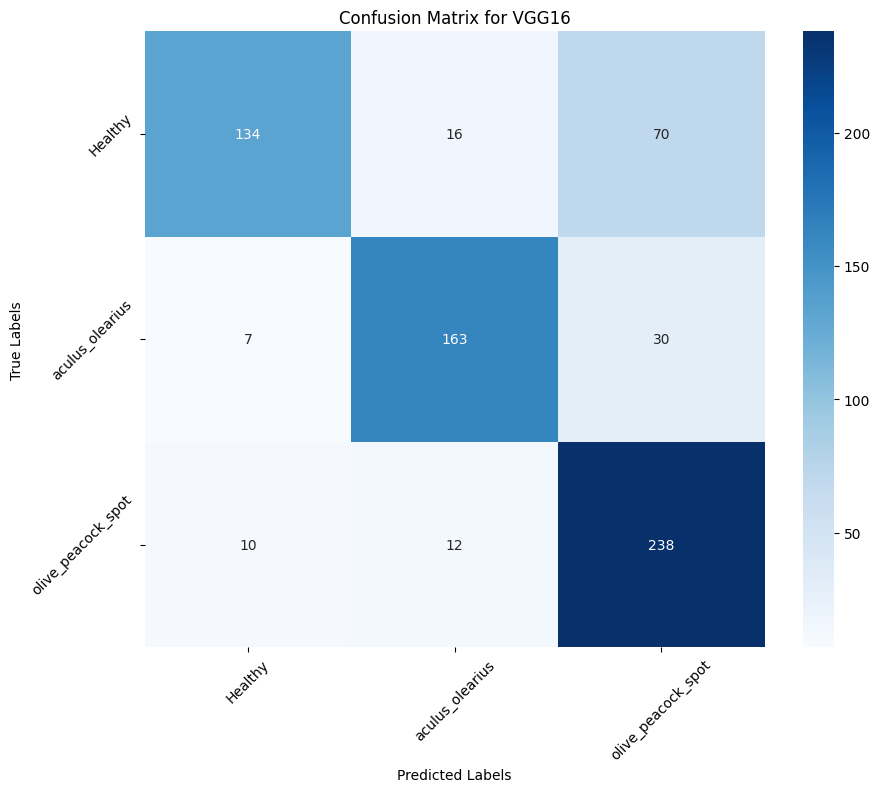

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.7782 - loss: 0.5653

🔹 VGG19 Test Accuracy: 0.7824

🔹 Classification Report for VGG19:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       220
           1       0.88      0.73      0.80       200
           2       0.73      0.89      0.80       260

    accuracy                           0.78       680
   macro avg       0.80      0.77      0.78       680
weighted avg       0.79      0.78      0.78       680


🔹 Confusion Matrix for VGG19:
[[155  13  52]
 [ 19 146  35]
 [ 23   6 231]]


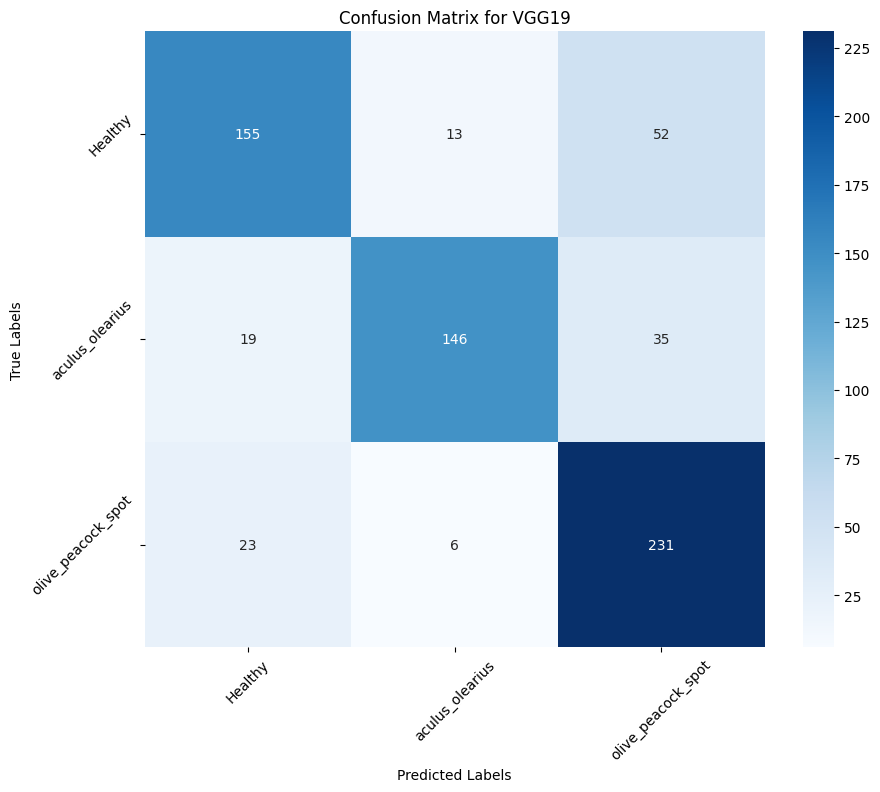

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9185 - loss: 0.2606

🔹 MobileNet Test Accuracy: 0.9162

🔹 Classification Report for MobileNet:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       220
           1       0.91      0.92      0.92       200
           2       0.90      0.93      0.91       260

    accuracy                           0.92       680
   macro avg       0.92      0.92      0.92       680
weighted avg       0.92      0.92      0.92       680


🔹 Confusion Matrix for MobileNet:
[[198   8  14]
 [  4 184  12]
 [  9  10 241]]


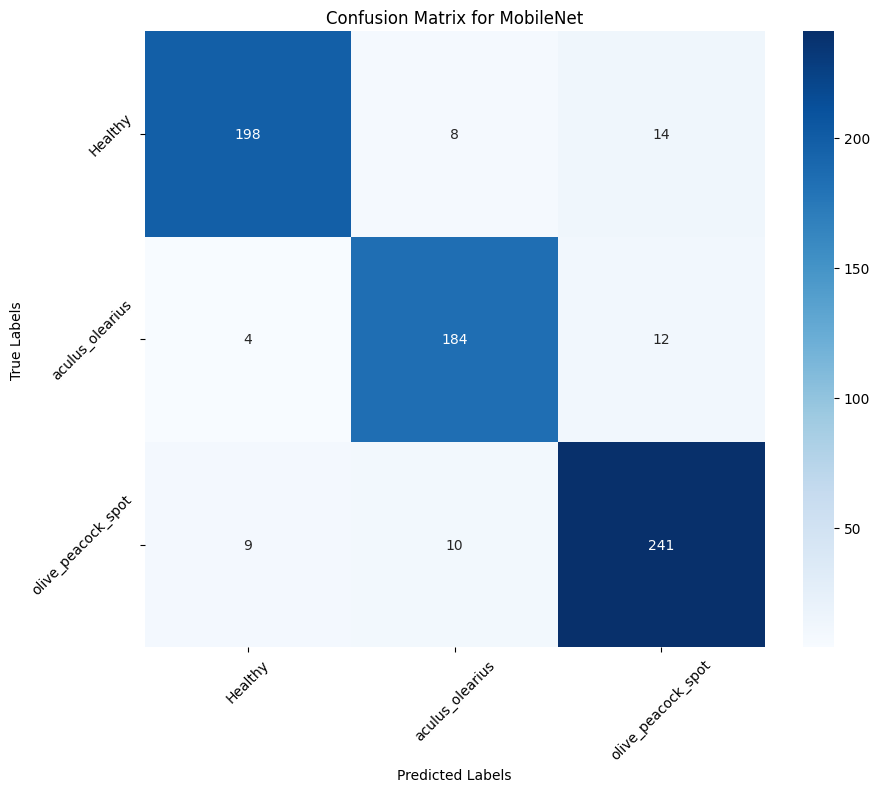

In [112]:

# Evaluate Models and Plot Confusion Matrix
def evaluate_model(model, test_generator, model_name):
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    y_true = test_generator.classes
    
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\n🔹 {model_name} Test Accuracy: {test_acc:.4f}")
    
    print(f"\n🔹 Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred))

    print(f"\n🔹 Confusion Matrix for {model_name}:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

# Evaluate VGG16, VGG19, MobileNetV3
evaluate_model(vgg16_model, test_generator, "VGG16")
evaluate_model(vgg19_model, test_generator, "VGG19")
evaluate_model(mobilenet_model, test_generator, "MobileNet")


## 5.Plotting Accuracy and Loss for all models


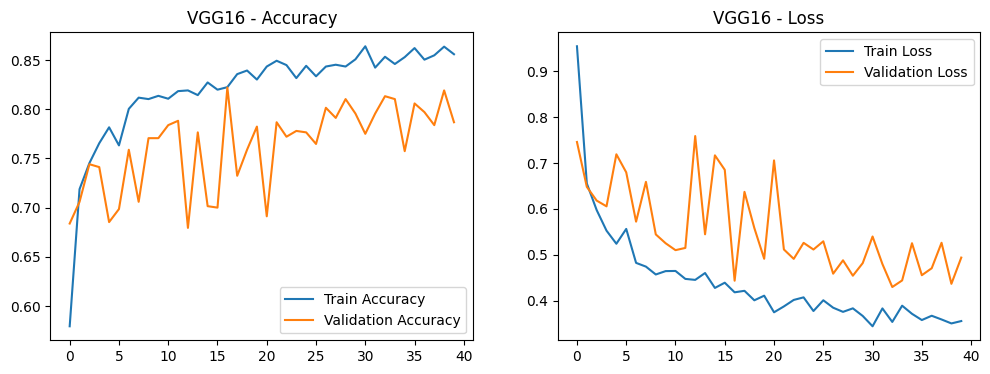

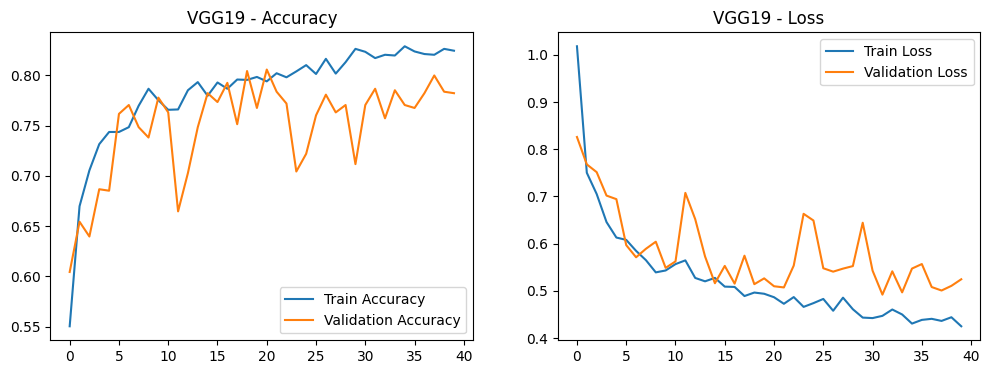

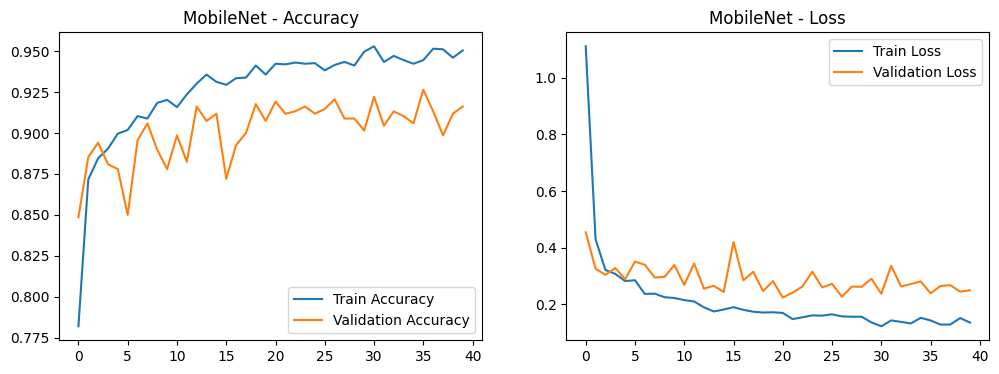

In [113]:

def plot_results(history, model_name):
    plt.figure(figsize=(12, 4))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss')

    plt.show()

# Plot for all models
plot_results(history_vgg16, "VGG16")
plot_results(history_vgg19, "VGG19")
plot_results(history_mobilenet, "MobileNet")

# Approach 5: Model Fine-Tune with data augmentation Using 3 Pre-trained CNN Model.
### VGG16,VGG19 and MobileNet

## 1.Build Model Function with Fine-Tuning 


In [115]:

def build_model(base_model, unfreeze_from=30):
   
    for i, layer in enumerate(base_model.layers):
        if i < unfreeze_from:
            layer.trainable = False
        else:
            layer.trainable = True
    
    x = Flatten()(base_model.output)
    x = Dense(1000, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation="softmax")(x)  # 3-class classification
    
    model = Model(inputs=base_model.input, outputs=x)
    # Use a low learning rate for fine-tuning
    model.compile(optimizer=Adam(learning_rate=1e-5), 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])
    return model

## 2.Load Pre-trained Base Models

In [116]:
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
vgg19_base = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
mobilenet_base = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

## 3.Build Final Models (Fine-Tuning: unfreeze layers from index 30)


In [117]:
vgg16_model = build_model(vgg16_base, unfreeze_from=30)
vgg19_model = build_model(vgg19_base, unfreeze_from=30)
mobilenet_model = build_model(mobilenet_base, unfreeze_from=30)

## 4.Data Augmentation


In [118]:

# For MobileNet (V1), we use its preprocess_input for proper scaling.
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

## 5.Create Data Generators ---


In [119]:
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/train',  # Update with your train dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/test',   # Update with your test dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2720 images belonging to 3 classes.
Found 680 images belonging to 3 classes.


## 6.Train the Models

In [120]:
print("🔹 Training VGG16 Model...")
history_vgg16 = vgg16_model.fit(train_generator, validation_data=test_generator, epochs=20, batch_size=32)

print("🔹 Training VGG19 Model...")
history_vgg19 = vgg19_model.fit(train_generator, validation_data=test_generator, epochs=20, batch_size=32)

print("🔹 Training MobileNet Model...")
history_mobilenet = mobilenet_model.fit(train_generator, validation_data=test_generator, epochs=20, batch_size=32)


🔹 Training VGG16 Model...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 408ms/step - accuracy: 0.4276 - loss: 1.1919 - val_accuracy: 0.5221 - val_loss: 0.9594
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 394ms/step - accuracy: 0.5873 - loss: 0.8584 - val_accuracy: 0.5985 - val_loss: 0.8411
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 399ms/step - accuracy: 0.7024 - loss: 0.7088 - val_accuracy: 0.5853 - val_loss: 0.8066
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 392ms/step - accuracy: 0.7500 - loss: 0.6291 - val_accuracy: 0.6853 - val_loss: 0.6951
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 386ms/step - accuracy: 0.7389 - loss: 0.6053 - val_accuracy: 0.7250 - val_loss: 0.6301
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 392ms/step - accuracy: 0.7627 - loss: 0.5762 - val_accuracy: 0.7044 - val_loss: 0.6491
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 392ms/step - accuracy: 0.7848 - loss: 0.5350 - val_accuracy: 0.7338 - val_loss: 0.5892
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 390ms/step - accuracy: 0.7954 - loss: 0.5237 - val_accuracy: 0.754

## 7.Evaluation Function


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.7363 - loss: 0.6178

🔹 VGG16 Test Accuracy: 0.7912

🔹 Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.91      0.63      0.74       220
           1       0.88      0.79      0.83       200
           2       0.70      0.93      0.80       260

    accuracy                           0.79       680
   macro avg       0.83      0.78      0.79       680
weighted avg       0.82      0.79      0.79       680


🔹 Confusion Matrix for VGG16:
[[138   9  73]
 [ 10 157  33]
 [  4  13 243]]


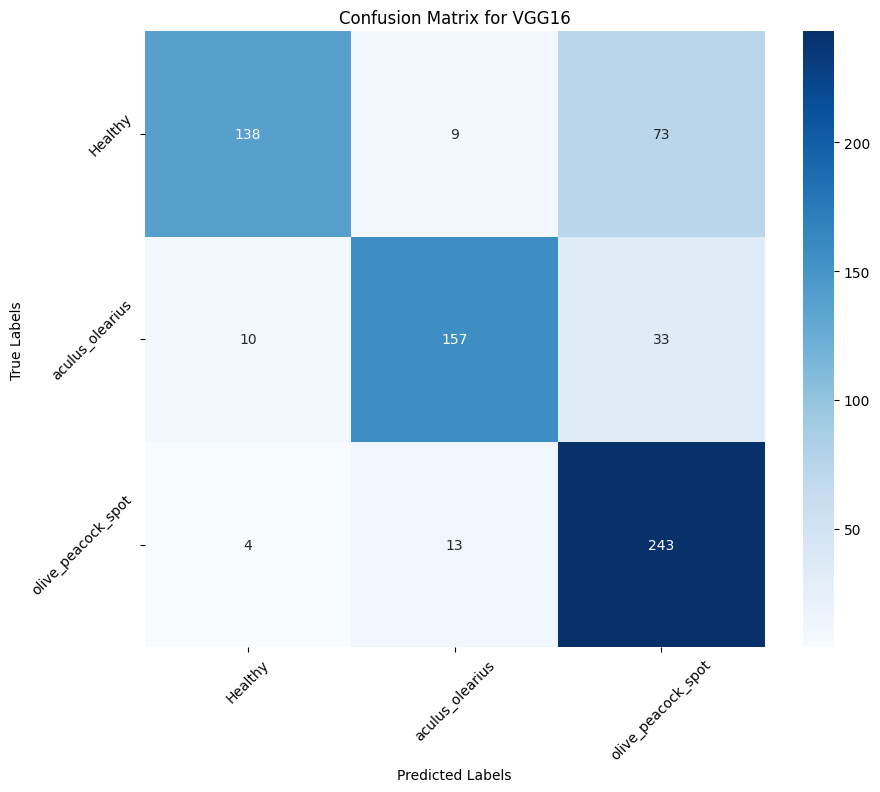

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.8093 - loss: 0.4750

🔹 VGG19 Test Accuracy: 0.8132

🔹 Classification Report for VGG19:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       220
           1       0.82      0.78      0.80       200
           2       0.78      0.90      0.84       260

    accuracy                           0.81       680
   macro avg       0.82      0.81      0.81       680
weighted avg       0.82      0.81      0.81       680


🔹 Confusion Matrix for VGG19:
[[164  17  39]
 [ 18 155  27]
 [ 10  16 234]]


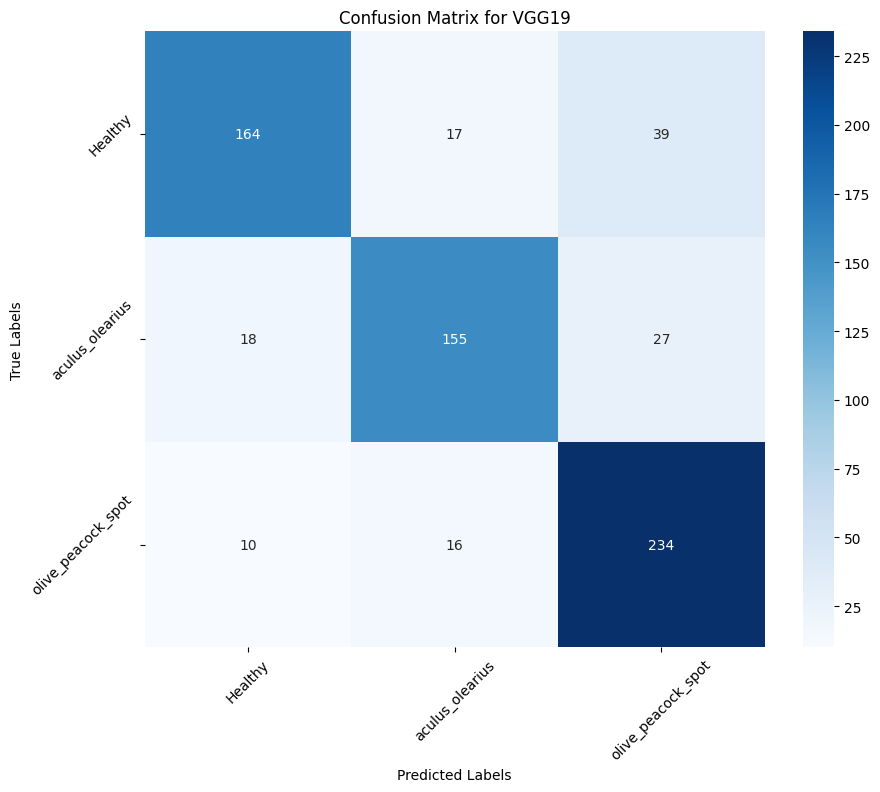

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.8813 - loss: 0.3014

🔹 MobileNet Test Accuracy: 0.9029

🔹 Classification Report for MobileNet:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       220
           1       0.91      0.95      0.93       200
           2       0.85      0.96      0.90       260

    accuracy                           0.90       680
   macro avg       0.91      0.90      0.90       680
weighted avg       0.91      0.90      0.90       680


🔹 Confusion Matrix for MobileNet:
[[175  11  34]
 [  0 190  10]
 [  3   8 249]]


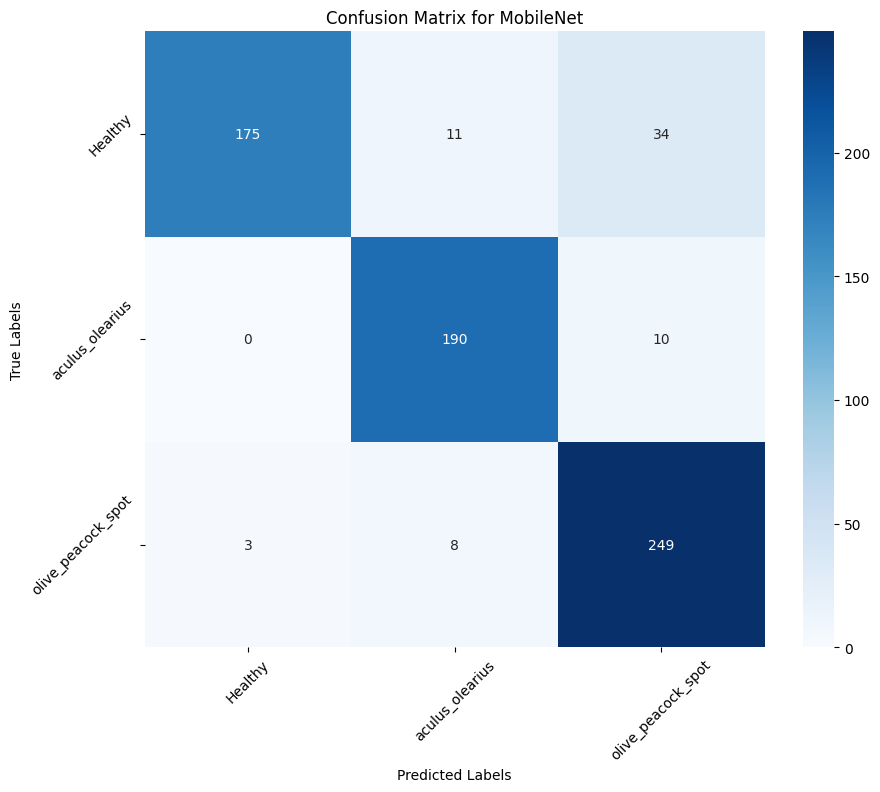

In [121]:
def evaluate_model(model, test_generator, model_name):
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    y_true = test_generator.classes
    
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\n🔹 {model_name} Test Accuracy: {test_acc:.4f}")
    
    print(f"\n🔹 Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n🔹 Confusion Matrix for {model_name}:")
    print(cm)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

# --- Evaluate Each Model ---
evaluate_model(vgg16_model, test_generator, "VGG16")
evaluate_model(vgg19_model, test_generator, "VGG19")
evaluate_model(mobilenet_model, test_generator, "MobileNet")



## 8.Plot Training History


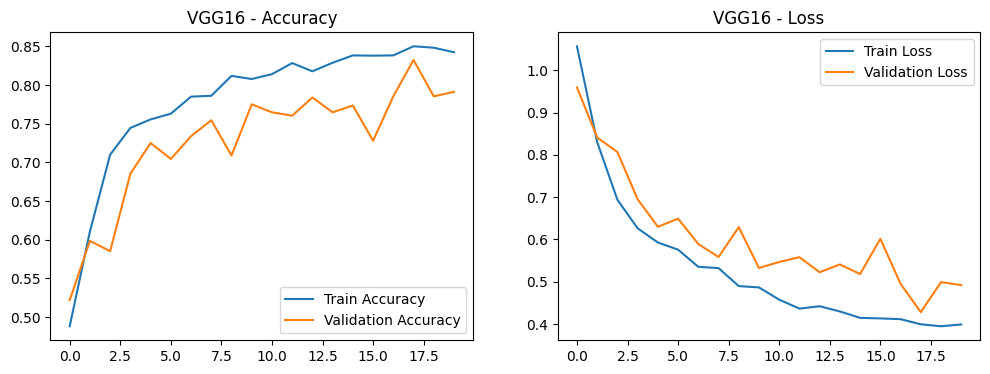

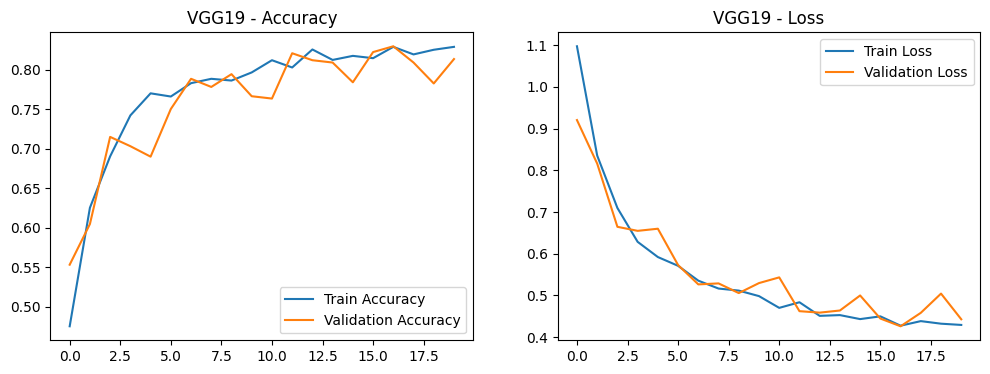

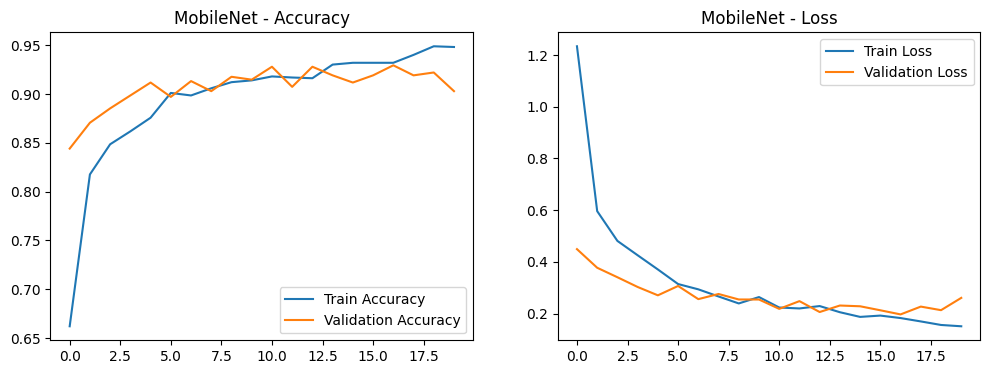

In [122]:

def plot_results(history, model_name):
    plt.figure(figsize=(12, 4))
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Accuracy')
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss')
    plt.show()

plot_results(history_vgg16, "VGG16")
plot_results(history_vgg19, "VGG19")
plot_results(history_mobilenet, "MobileNet")

# **All model test accuracy comparison**

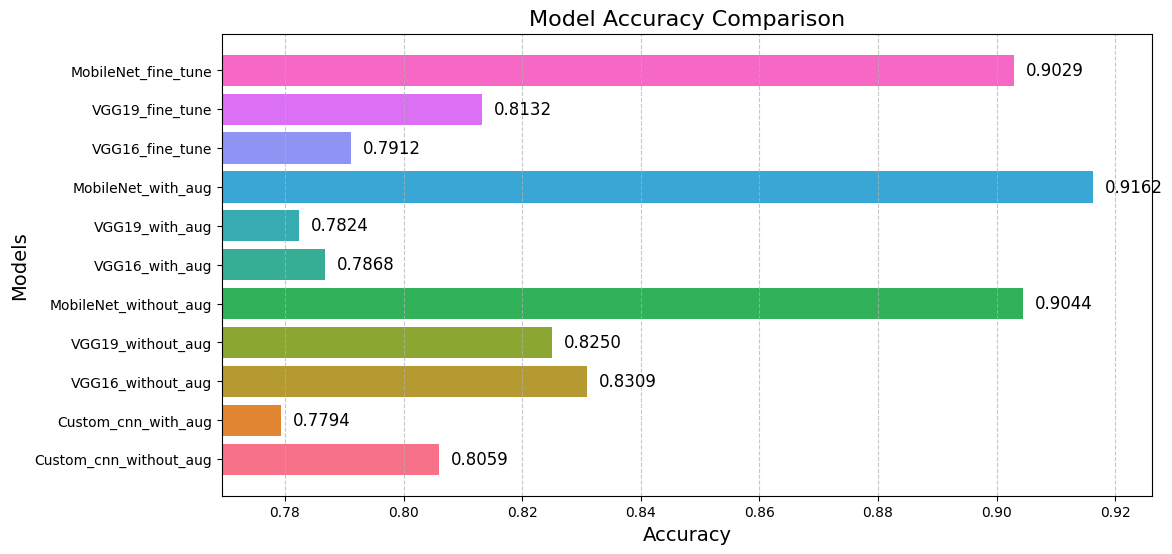

In [124]:


# Model names and their corresponding accuracy values
models = ["Custom_cnn_without_aug", "Custom_cnn_with_aug", "VGG16_without_aug", "VGG19_without_aug",
          "MobileNet_without_aug", "VGG16_with_aug", "VGG19_with_aug",
          "MobileNet_with_aug", "VGG16_fine_tune", "VGG19_fine_tune",
          "MobileNet_fine_tune"]

accuracies = [0.8059, 0.7794, 0.8309, 0.8250, 0.9044, 0.7868, 0.7824, 0.9162, 0.7912, 0.8132, 0.9029]

# Set the figure size
plt.figure(figsize=(12, 6))

# Generate a color palette with enough unique colors
colors = sns.color_palette("husl", len(models))  # "husl" generates distinct colors

# Create the horizontal bar chart
bars = plt.barh(models, accuracies, color=colors)

# Add accuracy values on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height() / 2, f"{acc:.4f}",
             va='center', fontsize=12)

# Labels and Title
plt.xlabel("Accuracy", fontsize=14)
plt.ylabel("Models", fontsize=14)
plt.title("Model Accuracy Comparison", fontsize=16)
plt.xlim(min(accuracies) - 0.01, max(accuracies) + 0.01)  # Adjust x-axis limits dynamically
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Save the plot (optional)
plt.savefig("model_accuracy_comparison.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()
